In [1]:
from mido import Message, MidiFile, MidiTrack,MetaMessage
import string
import numpy as np
import pandas as pd
import os
import csv

In [3]:
# convert msg to a dict
# output: [{'time': 341, 'note': 74, 'velocity': 66}, True]
def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]



In [4]:

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        result[note-21] = velocity if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]
def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

In [5]:
def mid2arry(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    sums = all_arys.sum(axis=1)
    ends = np.where(sums > 0)[0]
    return all_arys[min(ends): max(ends)]

In [18]:
# Path to your MIDI file
midi_file_path = r'D:\BrownUniversity\CS2470\final_proj\data\EMOPIA_1.0\midis\Q1__BK2o77sTc0_0.mid'

# Load the MIDI file
mid_test = MidiFile(midi_file_path)

mid_test.tracks[1][0]

for msg in mid_test.tracks[1]:
    msg = str(msg)
    print(msg2dict(msg))

[{'time': 341, 'note': 74, 'velocity': 66}, True]
[{'time': 2, 'note': 47, 'velocity': 50}, True]
[{'time': 125}, None]
[{'time': 119, 'note': 54, 'velocity': 54}, True]
[{'time': 192, 'note': 59, 'velocity': 64}, True]
[{'time': 155, 'note': 61, 'velocity': 61}, True]
[{'time': 138, 'note': 62, 'velocity': 58}, True]
[{'time': 137, 'note': 66, 'velocity': 60}, True]
[{'time': 148}, None]
[{'time': 2, 'note': 47, 'velocity': 0}, True]
[{'time': 3, 'note': 73, 'velocity': 78}, True]
[{'time': 1, 'note': 59, 'velocity': 0}, True]
[{'time': 0, 'note': 61, 'velocity': 0}, True]
[{'time': 0, 'note': 54, 'velocity': 0}, True]
[{'time': 1, 'note': 62, 'velocity': 0}, True]
[{'time': 1, 'note': 66, 'velocity': 0}, True]
[{'time': 2, 'note': 74, 'velocity': 0}, True]
[{'time': 0, 'note': 47, 'velocity': 57}, True]
[{'time': 92}, None]
[{'time': 88, 'note': 54, 'velocity': 60}, True]
[{'time': 170, 'note': 59, 'velocity': 57}, True]
[{'time': 146, 'note': 61, 'velocity': 59}, True]
[{'time': 172

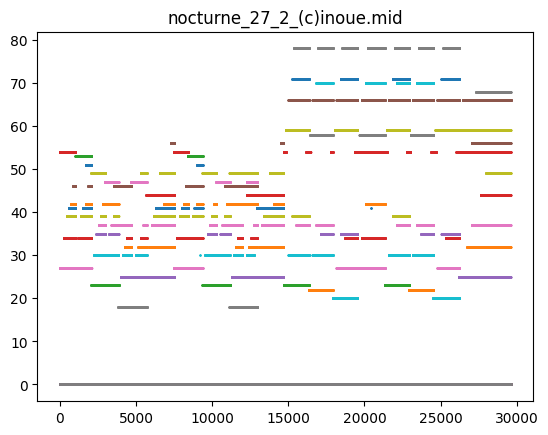

In [10]:
midi_file_path = r'D:\BrownUniversity\CS2470\final_proj\data\EMOPIA_1.0\midis\Q1__BK2o77sTc0_0.mid'
mid_test = MidiFile(midi_file_path)
result_array = mid2arry(mid_test)
import matplotlib.pyplot as plt
plt.plot(range(result_array.shape[0]), np.multiply(np.where(result_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("nocturne_27_2_(c)inoue.mid")
plt.show()

## Get whole data

In [6]:
# file_name
def file_name(midi_file_path):
    filename = os.path.basename(midi_file_path)
    filename_without_extension = os.path.splitext(filename)[0]
    return filename_without_extension

# get emotion label
def get_emo(label, target):
    for i in range(len(label)):
        if label.iloc[i,0] == target:
            return label.iloc[i,1]

In [9]:
# load the label
csv_file_path = r'D:\BrownUniversity\CS2470\final_proj\data\EMOPIA_1.0\label.csv'

# preprocess the label file
label = pd.read_csv(csv_file_path, delimiter='\t')
# seperate the first column
label[['name', '4Q', 'annotator']] = label['ID,4Q,annotator'].str.split(',', expand=True)
# drop the original column
label.drop(columns=['ID,4Q,annotator'], inplace=True) 
# print(label.iloc[:, 0]) # the first column
# shape:  [1078 rows x 3 columns]
print(len(label))


1078


In [97]:
# mid2array
midi_file_path = r'D:\BrownUniversity\CS2470\final_proj\data\EMOPIA_1.0\midis\Q4_XPLYvpyfKUM_0.mid'

mid_test = MidiFile(midi_file_path)
result_array = mid2arry(mid_test)
midi_lib = {}
midi_lib['midi_arr'] = result_array
name = file_name(midi_file_path)
emo = get_emo(label,name)
midi_lib['emo_label'] = emo

print(midi_lib)

# store_result_in_txt(midi_lib,'test1.txt')

{'midi_arr': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'emo_label': '4'}


In [23]:
# Define the folder path
folder_path = r'D:\BrownUniversity\CS2470\final_proj\data\EMOPIA_1.0\midis'

# Initialize an empty dictionary to store MIDI data
midi_lib = []

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is a MIDI file
    if file_name.endswith('.mid'):
        # Construct the full path to the MIDI file
        midi_file_path = os.path.join(folder_path, file_name)
        
        # Load the MIDI file
        mid_test = MidiFile(midi_file_path)
        
        # Convert MIDI to array
        result_array = mid2arry(mid_test)
        # file_name
        filename_without_extension = os.path.splitext(file_name)[0]
        # print(filename_without_extension)
        
        # Get the emotion label for the MIDI file
        emo = get_emo(label, filename_without_extension)
        # print(emo)
        
        # Add MIDI data and emotion label 
        midi_lib.append({'midi_arr': result_array, 'emo_label': emo})

        # midi_lib = {'midi_arr': result_array, 'emo_label': emo}


In [24]:
print(midi_lib)

[{'midi_arr': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'emo_label': '1'}, {'midi_arr': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'emo_label': '1'}, {'midi_arr': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'emo_label': '1'}, {'midi_arr': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'emo_label': '1'}, {'midi_arr': array([[0, 0, 0, ..., 0, 0, 0],
  

In [27]:
import json
import numpy as np
# Define the path to your output text file
json_file_path = r'D:\BrownUniversity\CS2470\final_proj\CS2470_final_project\data\midi_arry.json'  

# Convert NumPy arrays in each dictionary to lists
for entry in midi_lib:
    for key, value in entry.items():
        if isinstance(value, np.ndarray):
            entry[key] = value.tolist()

# Open the JSON file in write mode
with open(json_file_path, 'w') as json_file:
    # Write the dictionary data to the JSON file
    json.dump(midi_lib, json_file)

print(f"Dictionary data stored in JSON file: {json_file_path}")



Dictionary data stored in JSON file: D:\BrownUniversity\CS2470\final_proj\CS2470_final_project\data\midi_arry.json
